In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
import demes, demesdraw, matplotlib.pylab as plt

In [2]:
# Define Functions
def sample_timepoints(deme, time_points = 3, size = 100):
     sample_demes = list(np.repeat(np.array(deme),time_points))
     times = np.linspace(graph[deme].end_time+1,graph[deme].start_time-1,time_points,dtype=int) if graph[deme].start_time != float('inf') else np.linspace(graph[deme].end_time+1,graph[deme].end_time+4000,time_points,dtype=int)
     sizes = list(np.repeat(np.array(size),time_points))
     return sample_demes,times,sizes

def Dstat(graph,sampled_demes,sample_times,rhos):
     y = moments.Demes.LD(graph, sampled_demes=sampled_demes, sample_times=sample_times,rho = rhos)
     sigma = moments.LD.Inference.sigmaD2(y)
     return sigma

def plot_D(sigma,rhos,sample_times,subfig,ancestral):
     (ax1, ax2, ax3) = subfig.subplots(nrows=1, ncols=3)
     #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

     ax1.plot(rhos, sigma.LD()[:, 0],label=str("tp_"+str(sample_times[0])))
     ax1.plot(rhos, sigma.LD()[:, 3],label=str("tp_"+str(sample_times[1])))
     ax1.plot(rhos, sigma.LD()[:, 5],label=str("tp_"+str(sample_times[2])))
     ax1.plot(rhos, ancestral.LD()[:, 0],'--',label="Ancestral")

     ax2.plot(rhos, sigma.LD()[:, 6],label=str(sigma.names()[0][6])+"_tp_"+str(sample_times[0]))
     ax2.plot(rhos, sigma.LD()[:, 15],label=str(sigma.names()[0][15])+"_tp_"+str(sample_times[1]))
     ax2.plot(rhos, sigma.LD()[:, 23],label=str(sigma.names()[0][23])+"_tp_"+str(sample_times[2]))
     ax2.plot(rhos, ancestral.LD()[:, 1],'--',label="Ancestral")

     ax3.plot(rhos, sigma.LD()[:, 24],label=str(sigma.names()[0][24])+"_tp_"+str(sample_times[0]))
     ax3.plot(rhos, sigma.LD()[:, 39],label=str(sigma.names()[0][39])+"_tp_"+str(sample_times[1]))
     ax3.plot(rhos, sigma.LD()[:, 44],label=str(sigma.names()[0][44])+"_tp_"+str(sample_times[2]))
     ax3.plot(rhos, ancestral.LD()[:, 2],'--',label="Ancestral")

     ax1.set_yscale("log")
     ax2.set_yscale("log")
     ax3.set_yscale("log")
     ax1.set_xscale("log")
     ax2.set_xscale("log")
     ax3.set_xscale("log")
     ax1.set_xlabel(r"$\rho$")
     ax2.set_xlabel(r"$\rho$")
     ax3.set_xlabel(r"$\rho$")
     ax1.set_ylabel(r"$\sigma_d^2$")
     ax2.set_ylabel(r"$\sigma_{Dz}$")
     ax3.set_ylabel(r"Pi2")
     ax1.legend()
     #ax2.legend()
     ax3.legend()


In [3]:
# Specify DEMES Model parameters
N = 10e3 # Ancestral pop will have an N of N*populations
splits = 2 # How many split events after merging
populations = 3 # splits into populations 
proportions = [0.80,0.1,0.10,0.5,0.3,0.2] # proportions of N for new pops
assert len(proportions) == splits*populations
#proportions = 0
time_period = 0.1*N

events = splits*2+1
current_time = events*time_period

# set up recombination rates
rhos = np.logspace(-2, 2, 21)

### Cake model, with migration

In [4]:

# Create Builder
m = demes.Builder()

# Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
current_time = current_time-time_period

split = 1 # Logical variable to know whether or not a split should be modeled
previous = ["Ancestral"]

size_proportions = proportions.copy() if proportions else list(np.repeat(np.array([1/populations]),populations))

event = 0 
split_i = 0
while current_time > 0:
    if split:
        pops = []
        for pop in np.arange(populations):
            name="Split_" + str(event) + str(pop)
            # proportions=[size_proportions[0]]
            m.add_deme(name,ancestors=previous,start_time=current_time,epochs=[dict(start_size=populations*N*size_proportions[0],end_time=current_time-time_period)])
            pops.append(name)
            size_proportions.pop(0)
            print(size_proportions)
        previous = pops
        # m.add_migration(demes = pops, rate = 1e-4)
        current_time = current_time-time_period
        split = 0
    else: 
        assert len(previous) == len(list(np.repeat(np.array([1/populations]),populations)))
        name="Merge_" + str(event)
        m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/populations]),populations)),start_time=current_time,epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
        previous = [name]
        current_time = current_time-time_period
        split = 1
    event = event + 1 

# Resolver model
graph = m.resolve()

# Check demographic events
graph.discrete_demographic_events()

[0.1, 0.1, 0.5, 0.3, 0.2]
[0.1, 0.5, 0.3, 0.2]
[0.5, 0.3, 0.2]
[0.3, 0.2]
[0.2]
[]


{'pulses': [],
 'splits': [Split(parent='Ancestral', children=['Split_01', 'Split_02', 'Split_00'], time=4000.0),
  Split(parent='Merge_1', children=['Split_22', 'Split_20', 'Split_21'], time=2000.0)],
 'branches': [],
 'mergers': [Merge(parents=['Split_00', 'Split_01', 'Split_02'], proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], child='Merge_1', time=3000.0),
  Merge(parents=['Split_20', 'Split_21', 'Split_22'], proportions=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333], child='Merge_3', time=1000.0)],
 'admixtures': []}

<AxesSubplot:ylabel='time ago (generations)'>

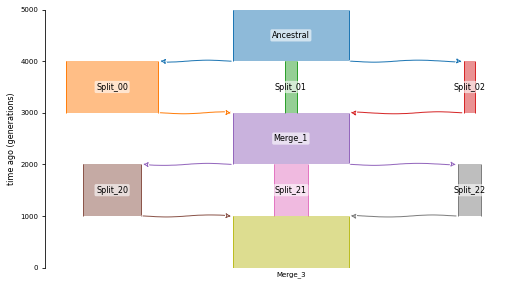

In [5]:
# 1. Specify model - if we are reading from a yaml file
#model = "/home/gfemer/storage/demography-simulations/IM_to_one.yaml"
#model = "/home/gfemer/storage/demography-simulations/example_demes.yaml"

# 2. Visualize Model with demes.draw
#graph = demes.load(model)
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [6]:
# Ancestral stats
sampled_demes, sample_times, sample_sizes = sample_timepoints('Ancestral',size = 100,time_points = 1)
Ds_ancestral = Dstat(graph, sampled_demes, sample_times,rhos)

### Same model, no migration

In [7]:

# 4. Sample from model different pops and different time points
# fig, axs = plt.subplots(nrows=len(graph.demes), ncols=2)
# plt.subplots_adjust(hspace=0.5)

fig = plt.figure(constrained_layout=True, figsize = (10,20))
#fig.suptitle('Figure title')

pops_plot = []
for deme in graph.demes:
        pops_plot.append(deme)

subfigs = fig.subfigures(nrows=len(pops_plot), ncols=1)

for pop,subfig in zip(pops_plot,subfigs):
        deme = pop.name
        subfig.suptitle(deme)
        sampled_demes, sample_times, sample_sizes = sample_timepoints(deme,size = 100,time_points = 3)
        print(np.flip(sample_times))
        Ds = Dstat(graph, sampled_demes, np.flip(sample_times),rhos)
        plot_D(Ds,rhos,sample_times,subfig,Ds_ancestral)

#plt.show()
plt.savefig('Figures/Dstat_pi_epochs_nonsymetrical_log_nomigration_reversedtime2.png')

[8000 6000 4001]


ValueError: deme[1] Ancestral_sampled_8000_0: ancestor deme 'Ancestral' not found. Note: ancestor demes must be specified before their children.

<Figure size 720x1440 with 0 Axes>

### Constant size, two pops

In [ ]:
# constant pop size model
# Create Builder
m = demes.Builder()
current_time = events*time_period

# Add first Ancestor
m.add_deme("Constant",epochs=[dict(start_size=populations*N,end_time=current_time-time_period)])
current_time = current_time-time_period

m.add_deme("Constant2",ancestors=['Constant'],epochs=[dict(start_size=populations*N)],start_time=current_time)
#m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/populations]),populations)),start_time=current_time,epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
# Resolver model
graph = m.resolve()

# Check demographic events
graph.discrete_demographic_events()

demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize = (10,7))
subfigs = fig.subfigures(nrows=2, ncols=1)

for pop,subfig in zip(graph.demes,subfigs):
        deme = pop.name
        subfig.suptitle(deme)
        sampled_demes, sample_times, sample_sizes = sample_timepoints(deme,size = 100,time_points = 3)
        Ds = Dstat(graph, sampled_demes, sample_times,rhos)
        plot_D(Ds,rhos,sample_times,subfig,Ds_ancestral)

plt.savefig('Figures/Dstat_pi_epochs_constant_twopops.png')

### Popsize Change same pop

In [ ]:
# Popsize Change

# Create Builder
m = demes.Builder()
current_time = events*time_period

# Add first Ancestor
# ,end_size=populations*N*0.4
m.add_deme("Deme",epochs=[dict(start_size=populations*N,end_time=current_time),dict(start_size=populations*N*0.4,end_time=0)])

#current_time = current_time-time_period
#m.add_deme("Constant2",ancestors=['Constant'],epochs=[dict(start_size=populations*N)],start_time=current_time)
#m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/populations]),populations)),start_time=current_time,epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
# Resolver model
graph = m.resolve()

# Check demographic events
graph.discrete_demographic_events()

ax = demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)
ax.figure.savefig("Figures/Onepop_Sizechange.jpg")

In [ ]:
fig = plt.figure(constrained_layout=True, figsize = (10,7))
subfigs = fig.subfigures(nrows=2, ncols=1)

times = [[5001,5500,5999],[1,3000,4999]]

# Ancestral stats
sampled_demes, sample_times, sample_sizes = sample_timepoints('Deme',size = 100,time_points = 1)
Ds_ancestral = Dstat(graph, sampled_demes,[6000],rhos)

i=0
for subfig in subfigs:
        deme = 'Deme'
        subfig.suptitle(deme)
        #sampled_demes, sample_times, sample_sizes = sample_timepoints(deme,size = 100,time_points = 3)
        Ds = Dstat(graph, ['Deme','Deme','Deme'],np.flip(times[i]),rhos)
        plot_D(Ds,rhos,np.flip(times[i]),subfig,Ds_ancestral)
        i=i+1

plt.savefig('Figures/Dstat_pi_epochs_constant_twopops_reversed.png')

In [ ]:
normal = moments.Demes.LD(graph, sampled_demes=['Deme','Deme','Deme'], sample_times=times[1],rho = rhos)
flipped = moments.Demes.LD(graph, sampled_demes=['Deme','Deme','Deme'], sample_times=np.flip(times[1]),rho = rhos)
flipped2 = moments.Demes.LD(graph, sampled_demes=['Deme','Deme','Deme'], sample_times=np.flip(times[1]),rho = rhos)

# normal.LD() == flipped.LD()
normal.LD() == flipped.LD()

### Same model, no splits. Different pops

In [ ]:
# Specify DEMES Model parameters
N = 10e3 # Ancestral pop will have an N of N*populations
splits = 2 # How many split events after merging
populations = 1 # splits into populations 
proportions = [0.5,0.3] # proportions of N for new pops
assert len(proportions) == splits*populations
#proportions = 0
time_period = 0.1*N

events = splits*2+1
current_time = events*time_period

# Create Builder
m = demes.Builder()

# Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
current_time = current_time-time_period

split = 1 # Logical variable to know whether or not a split should be modeled
previous = ["Ancestral"]

size_proportions = proportions.copy() if proportions else list(np.repeat(np.array([1/populations]),populations))

event = 0 
split_i = 0
while current_time > 0:
    if split:
        pops = []
        for pop in np.arange(populations):
            name="Split_" + str(event) + str(pop)
            # proportions=[size_proportions[0]]
            m.add_deme(name,ancestors=previous,start_time=current_time,epochs=[dict(start_size=populations*N*size_proportions[0],end_time=current_time-time_period)])
            pops.append(name)
            size_proportions.pop(0)
            print(size_proportions)
        previous = pops
        # m.add_migration(demes = pops, rate = 1e-4)
        current_time = current_time-time_period
        split = 0
    else: 
        assert len(previous) == len(list(np.repeat(np.array([1/populations]),populations)))
        name="Merge_" + str(event)
        m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/populations]),populations)),start_time=current_time,epochs=[dict(start_size=populations*N, end_time=current_time-time_period)])
        previous = [name]
        current_time = current_time-time_period
        split = 1
    event = event + 1 

# Resolver model
graph = m.resolve()

# Check demographic events
graph.discrete_demographic_events()

demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [ ]:
# 4. Sample from model different pops and different time points
# fig, axs = plt.subplots(nrows=len(graph.demes), ncols=2)
# plt.subplots_adjust(hspace=0.5)

fig = plt.figure(constrained_layout=True, figsize = (10,20))
#fig.suptitle('Figure title')

subfigs = fig.subfigures(nrows=len(graph.demes), ncols=1)

for pop,subfig in zip(graph.demes,subfigs):
        deme = pop.name
        subfig.suptitle(deme)
        sampled_demes, sample_times, sample_sizes = sample_timepoints(deme,size = 100,time_points = 3)
        Ds = Dstat(graph, sampled_demes, sample_times,rhos)
        plot_D(Ds,rhos,sample_times,subfig,Ds_ancestral)

#plt.show()
plt.savefig('Figures/Dstat_pi_epochs_nonsymetrical_log_nosplits.png')

### Shorter time steps